In [1]:
path='/Users/EveLo/Desktop/' # Location of Data in local PC
input_fn = 'EC_sales.csv' # Input file name
output_fn = 'prediction.csv' #Output file name

data_start = '2000-10-01' # Date of data used in creating prediction model
data_end = '2015-12-01'

predict_start = '2000-11-01' # Date of prediciton range; if exog is included, range of date should be consistent
predict_end = '2017-04-01'

test_start='2016-01-01' # Date of data used to test prediction (i.e calculate RSME/ visualize CI)
test_end='2016-12-01'

# #'''''''For models including exog parameters, use date index below instead: 
# data_start = '2000-10-01' # Date of data used in creating prediction model
# data_end = '2015-12-01'

# predict_start = '2000-11-01' # Date of prediciton range; if exog is included, range of date should be consistent
# predict_end = '2016-10-01'

# reg_test_start='2016-01-01' # Date of data used to test prediction (i.e calculate RSME/ visualize CI)
# reg_test_end='2016-10-01'

# #'''''''

arima_para=[0,1,1]
sarima_para=[0,1,1,12]

CI_alpha=0.2


In [2]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas import read_csv
from pandas import datetime

import statsmodels.api as sm 
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.graphics.tsaplots
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

def RMSE(data,model):
    return 'RMSE = %.4f'% np.sqrt(sum((model-data)**2)/len(model))

def write_to_csv(path,fn,result):
    result.to_csv(path+fn)


In [4]:
# Read data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv(path+input_fn, header=0,parse_dates=[0],index_col='Date',date_parser=dateparse)
print data.head(5)

ts=data['Sales'][data_start:data_end]
ts_adjusted=data['Sales(adjusted)'][data_start:data_end]
CPI=data['CPI']
print ts_adjusted.head(10)

diff=ts-ts.shift()
diff.dropna(inplace=True)
season=ts-ts.shift(12)
season.dropna(inplace=True)


                Sales    CPI  Sales(adjusted)
Date                                         
2000-10-01  211166.27  174.0      1213.599253
2000-11-01  389420.28  174.1      2236.762091
2000-12-01  209938.25  174.0      1206.541667
2001-01-01  208182.09  175.1      1188.932553
2001-02-01   68301.74  175.8       388.519568
Date
2000-10-01    1213.599253
2000-11-01    2236.762091
2000-12-01    1206.541667
2001-01-01    1188.932553
2001-02-01     388.519568
2001-03-01    1501.303746
2001-04-01     699.534765
2001-05-01     219.518233
2001-06-01     257.695786
2001-07-01     299.890422
Name: Sales(adjusted), dtype: float64


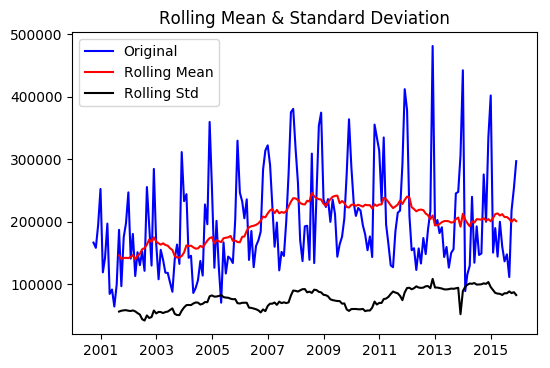

Results of Dickey-Fuller Test:
Test Statistic                  -1.984237
p-value                          0.293527
#Lags Used                      13.000000
Number of Observations Used    169.000000
Critical Value (5%)             -2.878799
Critical Value (1%)             -3.469648
Critical Value (10%)            -2.575971
dtype: float64


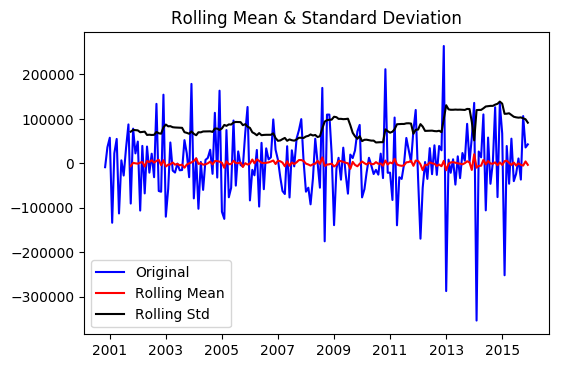

Results of Dickey-Fuller Test:
Test Statistic                -7.572411e+00
p-value                        2.818489e-11
#Lags Used                     1.200000e+01
Number of Observations Used    1.690000e+02
Critical Value (5%)           -2.878799e+00
Critical Value (1%)           -3.469648e+00
Critical Value (10%)          -2.575971e+00
dtype: float64


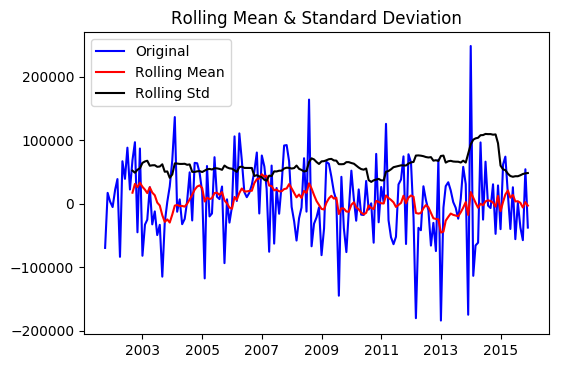

Results of Dickey-Fuller Test:
Test Statistic                  -4.083567
p-value                          0.001031
#Lags Used                      11.000000
Number of Observations Used    159.000000
Critical Value (5%)             -2.879895
Critical Value (1%)             -3.472161
Critical Value (10%)            -2.576557
dtype: float64


In [17]:
# Check stationality for timeseries data and use differencing to decide parameter in SARIMAX
ts_data=ts
ts_data.dropna(inplace=False)
# Stationality testing for original data
test_stationarity(ts_data)
# Stationality testing for original data with 1st differencing
test_stationarity(diff)
# Stationality testing for original data with seasonal differencing
test_stationarity(season)

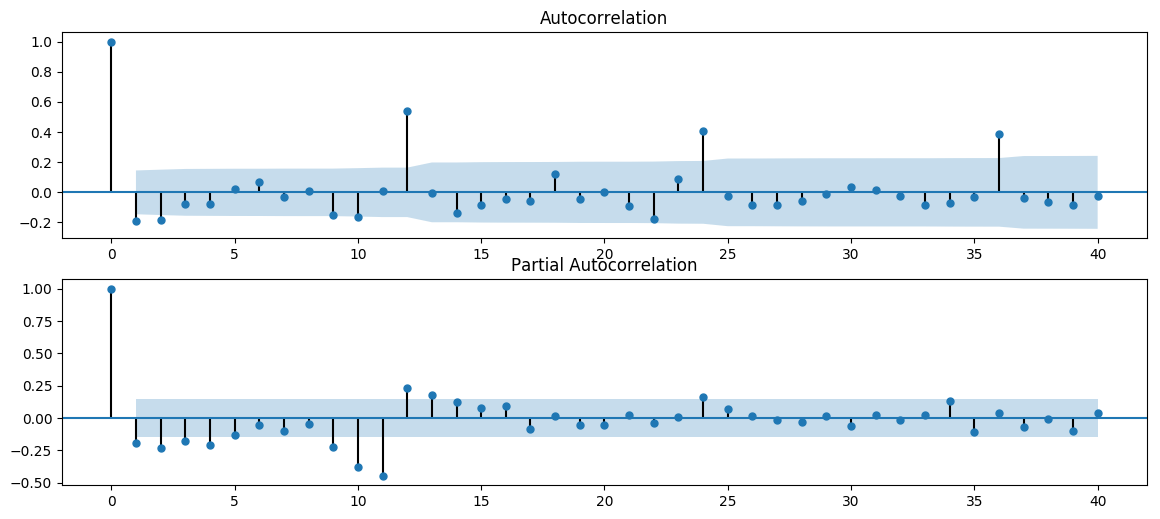

In [97]:
#ACF and PACF checking
acf_data = diff

acf_data.dropna(inplace=True)
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(acf_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(acf_data, lags=40, ax=ax2)

# SARIMAX model :  Sales

2016-01-01~2016-12-01: RMSE = 629659.8687


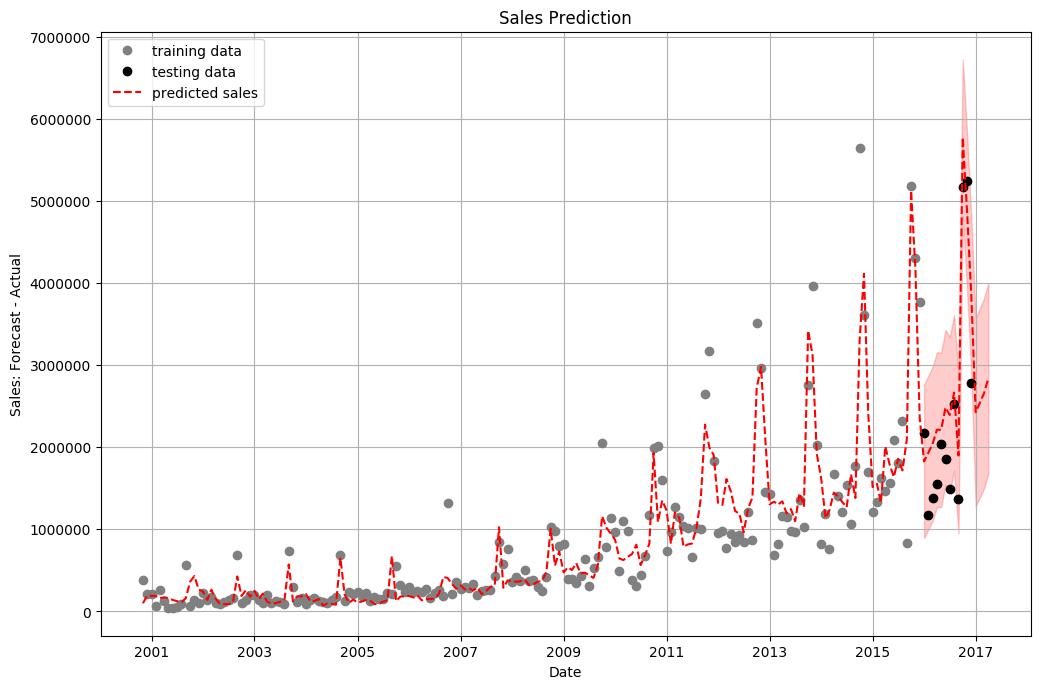

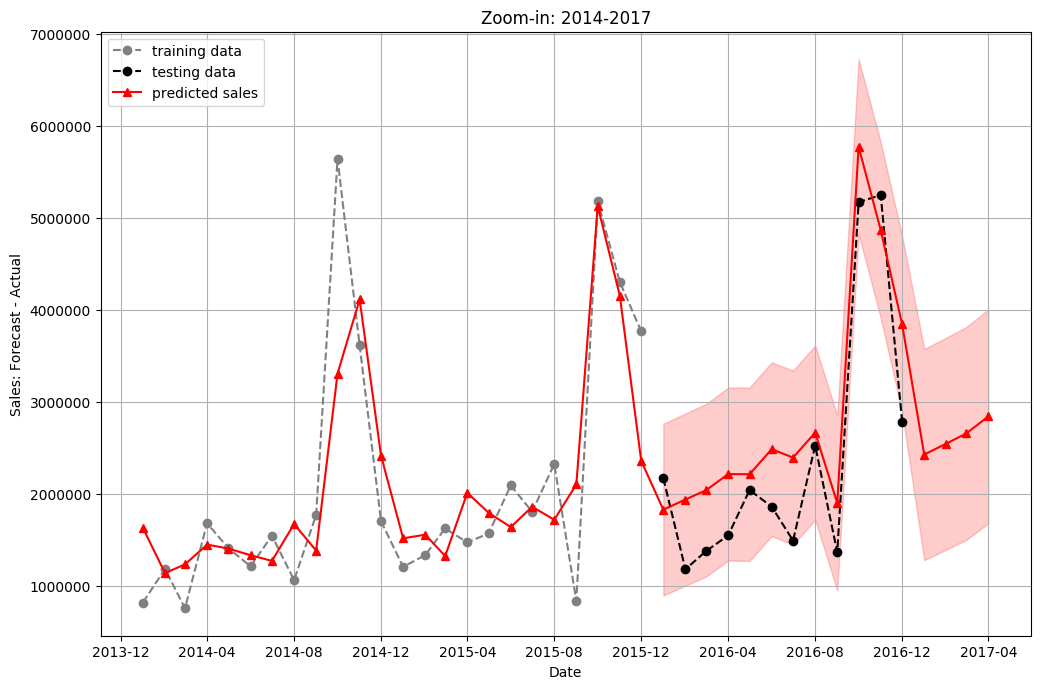

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  183
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2433.424
Date:                            Thu, 09 Mar 2017   AIC                           4876.849
Time:                                    09:32:02   BIC                           4892.896
Sample:                                10-01-2000   HQIC                          4883.354
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5826.9531   1.01e+04     -0.579      0.562   -2.55e+04    1.39e+04
drift         77.9457     80.911   

In [5]:
mod = sm.tsa.statespace.SARIMAX(ts, trend='ct', order=(arima_para[0],arima_para[1],arima_para[2]), 
                                seasonal_order=(sarima_para[0],sarima_para[1],sarima_para[2],sarima_para[3]),
                               enforce_invertibility=False).fit()

# Get prediction mean & CI 
pred_res = mod.get_prediction(start = predict_start, end= predict_end, typ='levels',full_results=True,alpha=CI_alpha)
predict_mean = pred_res.predicted_mean
pred_cis = pred_res.conf_int()


# Print out RSS and RMSE for testing period
print test_start+'~'+test_end+': '+RMSE(predict_mean[test_start:test_end], data['Sales'][test_start:test_end])

# Plot data and prediction+CI 
fig, ax = plt.subplots(figsize=(12,8))
ax.set(title='Sales Prediction', xlabel='Date', ylabel='Sales: Forecast - Actual')

plt.plot(data['Sales'][predict_start:data_end],color='grey',marker='o',ls='None',label='training data')
plt.plot(data['Sales'][test_start:test_end],color='black',marker='o',ls='None',label='testing data')
plt.plot(predict_mean[predict_start:predict_end],ls='--',color='red',label='predicted sales')
ci = pred_cis.ix[test_start:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=CI_alpha)

ax.grid(True)
legend = ax.legend(loc='upper left')
plt.show()

# Plot zoom-in graph
fig, ax = plt.subplots(figsize=(12,8))
ax.set(title='Zoom-in: 2014-2017', xlabel='Date', ylabel='Sales: Forecast - Actual')

plt.plot(data['Sales']['2014':data_end],color='grey',marker='o',ls='--',label='training data')
plt.plot(data['Sales'][test_start:test_end],color='black',marker='o',ls='--',label='testing data')
plt.plot(predict_mean['2014':'2017'],color='red',label='predicted sales',marker='^')
ci = pred_cis.ix[test_start:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.2)

ax.grid(True)
legend = ax.legend(loc='upper left')
plt.show()
print mod.summary()

# write_to_csv(path,output_fn,prediction_mean)

# SARIMAX model :  Sales/CPI

2016-01-01~2016-12-01: RMSE = 497993.1371


/Users/EveLo/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


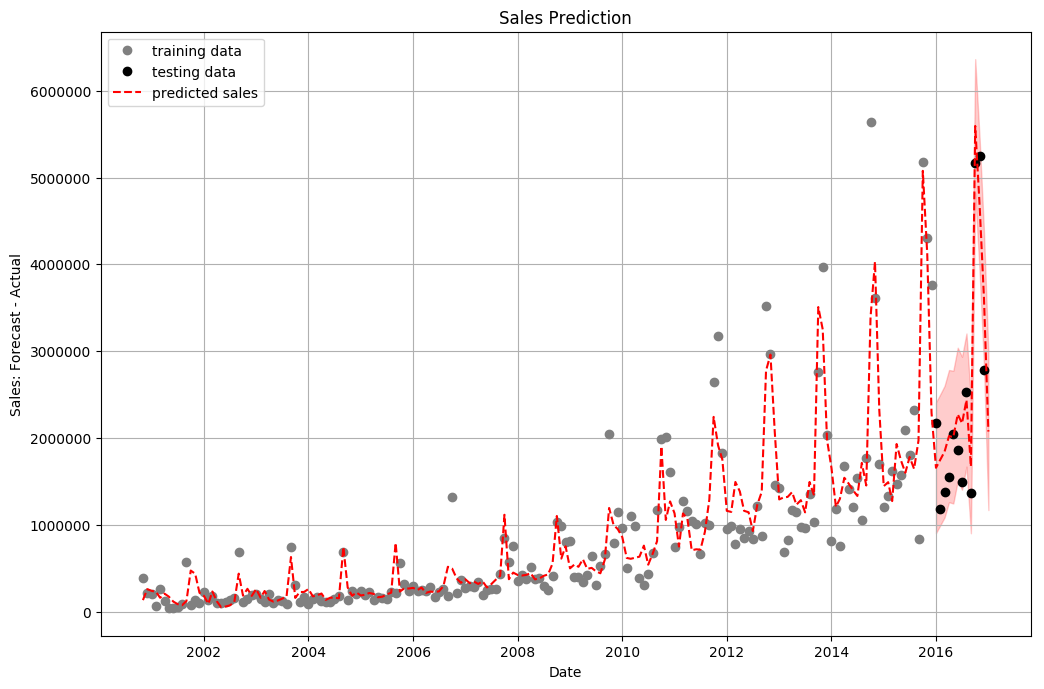

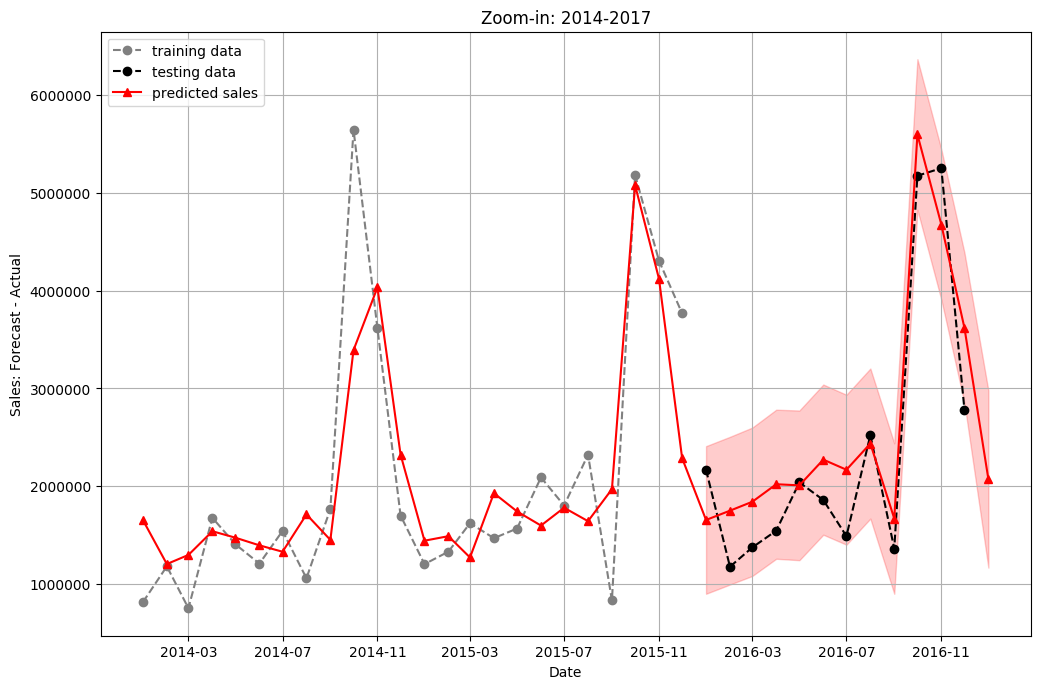

                                 Statespace Model Results                                 
Dep. Variable:                    Sales(adjusted)   No. Observations:                  183
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1500.117
Date:                            Thu, 09 Mar 2017   AIC                           3010.234
Time:                                    09:34:07   BIC                           3026.282
Sample:                                10-01-2000   HQIC                          3016.739
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.9741     10.476      0.570      0.568     -14.559      26.507
drift          0.0273      0.097   

In [6]:


mod = sm.tsa.statespace.SARIMAX(ts_adjusted, trend='ct', order=(arima_para[0],arima_para[1],arima_para[2]), 
                                seasonal_order=(sarima_para[0],sarima_para[1],sarima_para[2],sarima_para[3]),enforce_invertibility=False).fit()

# Get prediction mean & CI
pred_res = mod.get_prediction(start = predict_start, end= predict_end, full_results=True,typ='levels',alpha=0.05,dynamics=True)
predict_mean = pred_res.predicted_mean
pred_cis = pred_res.conf_int()


predict_mean=predict_mean*CPI
pred_cis['upper Sales(adjusted)']=pred_cis['upper Sales(adjusted)']*CPI
pred_cis['lower Sales(adjusted)']=pred_cis['lower Sales(adjusted)']*CPI


# Print out RSS and RMSE for testing period

print test_start+'~'+test_end+': '+RMSE(predict_mean[test_start:test_end], data['Sales'][test_start:test_end])


fig, ax = plt.subplots(figsize=(12,8))
ax.set(title='Sales Prediction', xlabel='Date', ylabel='Sales: Forecast - Actual')

plt.plot(data['Sales'][predict_start:data_end],color='grey',marker='o',ls='None',label='training data')
plt.plot(data['Sales'][test_start:test_end],color='black',marker='o',ls='None',label='testing data')
plt.plot(predict_mean[predict_start:predict_end],ls='--',color='red',label='predicted sales')
ci = pred_cis.ix[test_start:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.2)

ax.grid(True)
legend = ax.legend(loc='upper left')


# Plot zoom-in graph
fig, ax = plt.subplots(figsize=(12,8))
ax.set(title='Zoom-in: 2014-2017', xlabel='Date', ylabel='Sales: Forecast - Actual')

plt.plot(data['Sales']['2014':data_end],color='grey',marker='o',ls='--',label='training data')
plt.plot(data['Sales'][test_start:test_end],color='black',marker='o',ls='--',label='testing data')
plt.plot(predict_mean['2014':'2017'],color='red',label='predicted sales',marker='^')
ci = pred_cis.ix[test_start:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.2)

ax.grid(True)
legend = ax.legend(loc='upper left')
plt.show()

print mod.summary()

#write_to_csv(path,output_fn,predict_mean)

<h2>Regressors</h2>

<p>
<strong>Index:</strong>'2000-10','2000-11',.....'2017-12'  
</p>          

<p>
<strong>[Rate (USD/JPY)]</strong><br />
length = 197 ('2000-10'-'2017-02')<br />
Exchange rate between USD and JPY from '2000-07' to '2016-11. Exchange rates recorded 3 months ago are used for prediction at each time point.<br />
i.e. To predict sales at '2010-10', [Rate (USD/JPY)]  at '2010-07' is required.
</p>

<p>
<strong>[EC sales (2000Q3)]</strong><br />
length = 193 ('2000-10'-'2016-10')<br />
source : https://www.census.gov/retail/ecommerce/historic_releases.html<br />
United States Quarterly Retail E-commerce Sales Report. Monthly data are generated linearly between quaterly records. First data point is from 2000Q3  <br />
</p>
<p>
<strong>[US Category Store Sales(B)]</strong><br />
length = 197 ('2000-10'-'2017-02')<br/>
source: 'US Electronics and Appliance Store Sales on Ychart/FRED Economic Data <br />
US Electronics and Appliance Store Monthly Sales from '2000-09' to '2017-01'. Sales record one month ago are used for prediction at each time point.<br />
i.e. To predict sales at '2010-10', [Rate (USD/JPY)]  at '2010-09' is required.
</p>
<p>
<strong>[Temp]</strong><br />
length = 195 ('2000-10'-'2016-12')<br />
Monthly average temperature (degree-F) in California from '2000-10'-'2016-12'.
</p>

In [19]:
##################################
#        Import regressors       #
##################################
path='/Users/EveLo/Desktop/'
fnr='regressors.csv'
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
reg_ca = pd.read_csv(path+fnr, header=0,parse_dates=[0],index_col='Date',date_parser=dateparse)



reg = reg_ca[data_start:data_end]
reg_test = reg_ca[reg_test_start:reg_test_end]

# SARIMAX model :  Sales+ Regressors (#=3)

In [ ]:
mod_reg = sm.tsa.statespace.SARIMAX(ts, trend='ct', order=(arima_para[0],arima_para[1],arima_para[2]), 
                                       seasonal_order=(sarima_para[0],sarima_para[1],sarima_para[2],sarima_para[3]),
                                       exog=reg,enforce_invertibility=False).fit()

# Get prediction & CI 
pred_res_reg = mod_reg.get_prediction(start = predict_start, end=predict_end,exog=reg_test,typ='levels',full_results=True,alpha=CI_alpha,dynamics=True)
predict_mean_reg = pred_res_reg.predicted_mean
pred_cis_reg = pred_res_reg.conf_int()


print RMSE(predict_mean_reg[reg_test_start:reg_test_end], data['Sales'][reg_test_start:reg_test_end])


fig, ax = plt.subplots(figsize=(12,8))
ax.set(title='SARIMAX Sales Prediction', xlabel='Date', ylabel='Sales: Forecast - Actual')

plt.plot(data['Sales'][data_start:data_end],color='grey',marker='o',ls='None',label='training data')
plt.plot(data['Sales'][reg_test_start:reg_test_end],color='black',marker='o',ls='None',label='testing data')
plt.plot(predict_mean_reg[predict_start:predict_end],ls='--',color='orange',label='predicted sales')
ci = pred_cis_reg.ix[reg_test_start:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='orange', alpha=CI_alpha)

ax.grid(True)
legend = ax.legend(loc='upper left')


# Plot zoom-in graph
fig, ax = plt.subplots(figsize=(12,8))
ax.set(title='Zoom-in: 2014-2017', xlabel='Date', ylabel='Sales: Forecast - Actual')

plt.plot(data['Sales']['2014':reg_test_end],color='grey',marker='o',ls='--',label='training data')
plt.plot(data['Sales'][reg_test_start:reg_test_end],color='black',marker='o',ls='--',label='testing data')
plt.plot(predict_mean_reg['2014':reg_test_end],color='orange',label='predicted sales',marker='^')
ci = pred_cis_reg.ix[reg_test_start:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='orange', alpha=CI_alpha)

ax.grid(True)
legend = ax.legend(loc='upper left')

plt.show()


print mod_reg.summary()

# SARIMAX model :  Sales/CPI+ Regressors (#=3)

RMSE = 84104.9803


/Users/EveLo/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


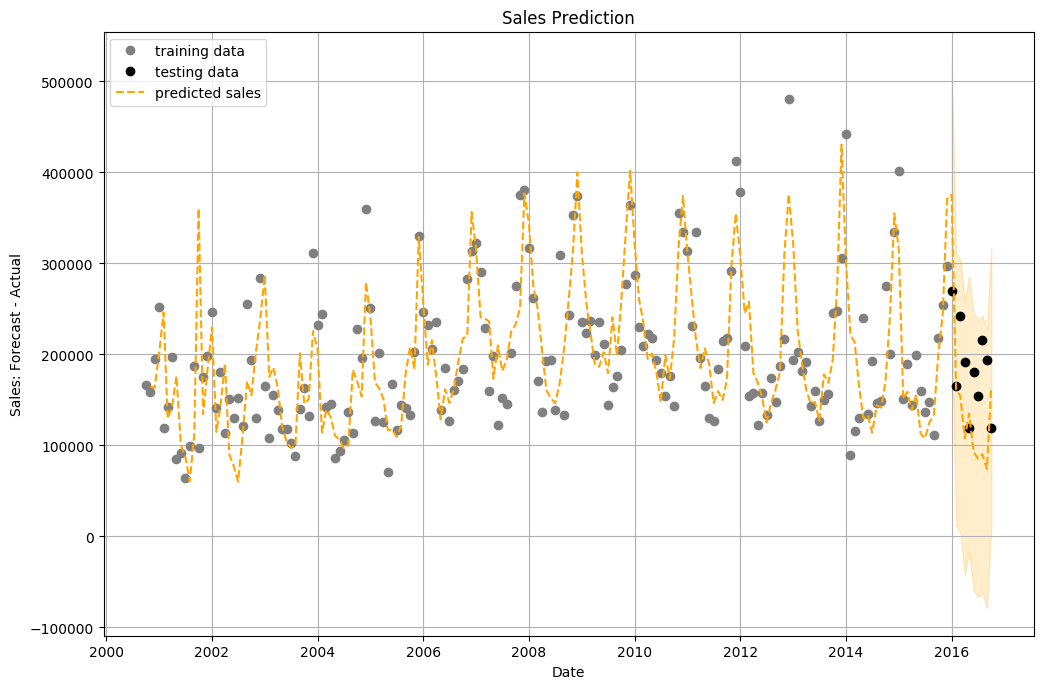

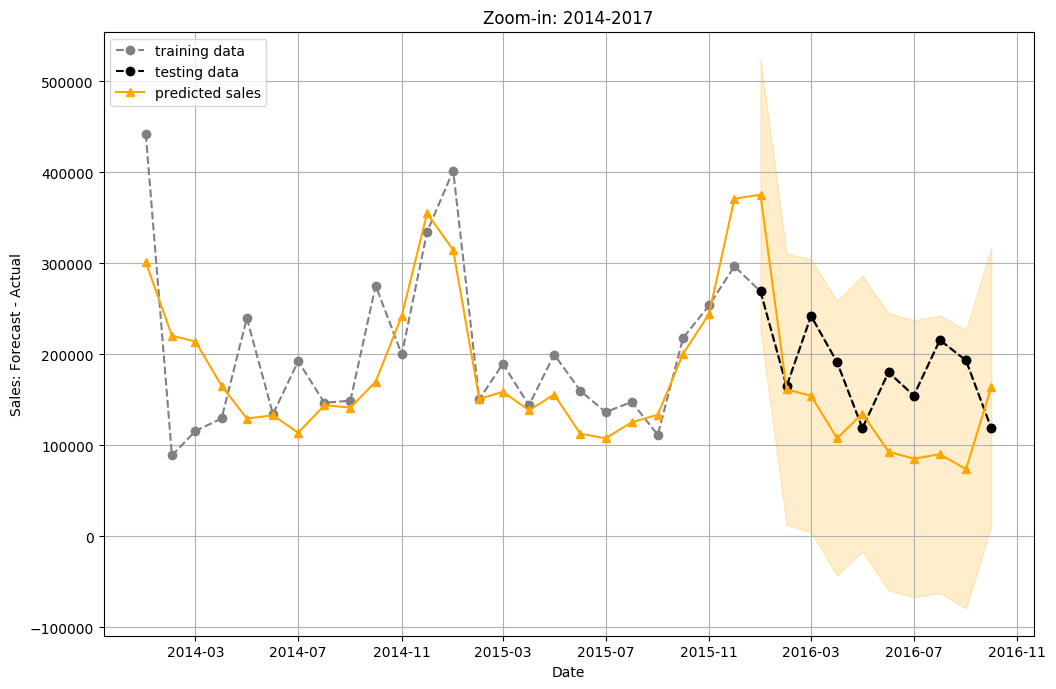

                                 Statespace Model Results                                 
Dep. Variable:                    Sales(adjusted)   No. Observations:                  183
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -1190.369
Date:                            Tue, 07 Mar 2017   AIC                           2400.738
Time:                                    13:29:39   BIC                           2432.833
Sample:                                10-01-2000   HQIC                          2413.747
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                      2.0995      3.771      0.557      0.578      -5.292

In [20]:
mod_reg = sm.tsa.statespace.SARIMAX(ts_adjusted, trend='ct', order=(arima_para[0],arima_para[1],arima_para[2]), 
                                       seasonal_order=(sarima_para[0],sarima_para[1],sarima_para[2],sarima_para[3]),
                                       exog=reg,enforce_invertibility=False).fit()

# Get prediction & CI 
pred_res_reg = mod_reg.get_prediction(start = predict_start, end=predict_end,exog=reg_test,typ='levels',full_results=True,alpha=CI_alpha,dynamics=True)
predict_mean_reg = pred_res_reg.predicted_mean
pred_cis_reg = pred_res_reg.conf_int()


predict_mean_reg=predict_mean_reg*CPI
pred_cis_reg['upper Sales(adjusted)']=pred_cis_reg['upper Sales(adjusted)']*CPI
pred_cis_reg['lower Sales(adjusted)']=pred_cis_reg['lower Sales(adjusted)']*CPI


print RMSE(predict_mean_reg[reg_test_start:reg_test_end], data['Sales'][reg_test_start:reg_test_end])

fig, ax = plt.subplots(figsize=(12,8))
ax.set(title='Sales Prediction', xlabel='Date', ylabel='Sales: Forecast - Actual')

plt.plot(data['Sales'][data_start:data_end],color='grey',marker='o',ls='None',label='training data')
plt.plot(data['Sales'][reg_test_start:reg_test_end],color='black',marker='o',ls='None',label='testing data')
plt.plot(predict_mean_reg[predict_start:predict_end],ls='--',color='orange',label='predicted sales')

ci = pred_cis_reg.ix[reg_test_start:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='orange', alpha=0.2)

ax.grid(True)
legend = ax.legend(loc='upper left')


# Plot zoom-in graph
fig, ax = plt.subplots(figsize=(12,8))
ax.set(title='Zoom-in: 2014-2017', xlabel='Date', ylabel='Sales: Forecast - Actual')

plt.plot(data['Sales']['2014':reg_test_end],color='grey',marker='o',ls='--',label='training data')
plt.plot(data['Sales'][reg_test_start:reg_test_end],color='black',marker='o',ls='--',label='testing data')
plt.plot(predict_mean_reg['2014':predict_end],color='orange',label='predicted sales',marker='^')
ci = pred_cis_reg.ix[reg_test_start:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='orange', alpha=0.2)

ax.grid(True)
legend = ax.legend(loc='upper left')

plt.show()

print mod_reg.summary()

In [149]:
df1 = pd.Series(data['Sales'],name='Sales')
pred=mod.predict(start = predict_start, end= predict_end, full_results=True,typ='levels',alpha=0.05,dynamics=True)
df2=pd.Series(pred*CPI,name='Prediction')
result=pd.concat([df1,df2])
print df1.tail(15)
print df2.tail(15)
print result.head(5)

Date
2016-10-01    5173189.58
2016-11-01    5250064.44
2016-12-01    2780829.13
2017-01-01    2490033.26
2017-02-01           NaN
2017-03-01           NaN
2017-04-01           NaN
2017-05-01           NaN
2017-06-01           NaN
2017-07-01           NaN
2017-08-01           NaN
2017-09-01           NaN
2017-10-01           NaN
2017-11-01           NaN
2017-12-01           NaN
Name: Sales, dtype: float64
2016-10-01    5.615254e+06
2016-11-01    4.693152e+06
2016-12-01    3.640919e+06
2017-01-01    2.093693e+06
2017-02-01             NaN
2017-03-01             NaN
2017-04-01             NaN
2017-05-01             NaN
2017-06-01             NaN
2017-07-01             NaN
2017-08-01             NaN
2017-09-01             NaN
2017-10-01             NaN
2017-11-01             NaN
2017-12-01             NaN
Name: Prediction, dtype: float64
2000-10-01    211166.27
2000-11-01    389420.28
2000-12-01    209938.25
2001-01-01    208182.09
2001-02-01     68301.74
dtype: float64


In [169]:
residual=(np.absolute(df2-df1)/df1)*100
res=df2/df1
print resi_slip

2014-01-01    -2.399737
2014-02-01    98.227185
2014-03-01    28.713182
2014-04-01    91.558745
2014-05-01    95.616573
2014-06-01    85.050936
2014-07-01    85.908128
2014-08-01    38.988979
2014-09-01    81.864232
2014-10-01    59.965842
2014-11-01    88.478245
2014-12-01    63.079508
2015-01-01    79.986760
2015-02-01    88.034246
2015-03-01    78.347023
2015-04-01    68.640114
2015-05-01    88.667178
2015-06-01    76.521758
2015-07-01    98.836581
2015-08-01    70.831155
2015-09-01   -36.855676
2015-10-01    98.319085
2015-11-01    95.771121
2015-12-01    60.776090
2016-01-01    76.497730
2016-02-01    50.475265
2016-03-01    65.155033
2016-04-01    68.572005
2016-05-01    99.173619
2016-06-01    76.965370
2016-07-01    53.422003
2016-08-01    97.220574
2016-09-01    76.646295
2016-10-01    91.454702
2016-11-01    89.392271
2016-12-01    69.070740
2017-01-01    84.082919
2017-02-01          NaN
2017-03-01          NaN
2017-04-01          NaN
2017-05-01          NaN
2017-06-01      

In [38]:
write_to_csv(path,'CA_waterboiler_residual.csv',residual)

In [36]:
residual= predict_mean-data['Sales']
print residual

2000-10-01              NaN
2000-11-01      1534.072558
2000-12-01    -36338.616396
2001-01-01    -59406.821805
2001-02-01    129694.527214
2001-03-01    -12474.757855
2001-04-01    -55513.754741
2001-05-01    108970.608709
2001-06-01      1617.064094
2001-07-01     26999.032237
2001-08-01    -32838.937629
2001-09-01    -86383.427227
2001-10-01    169699.280493
2001-11-01    -63756.930311
2001-12-01    -20063.135412
2002-01-01    -12529.908428
2002-02-01    -26161.033919
2002-03-01    -41097.945269
2002-04-01     82277.650099
2002-05-01    -73817.301815
2002-06-01    -39732.769518
2002-07-01    -81525.198261
2002-08-01     -7072.659973
2002-09-01    -65280.046695
2002-10-01    -30594.780429
2002-11-01     73834.074090
2002-12-01    -62730.173476
2003-01-01    118034.415084
2003-02-01     42917.086829
2003-03-01     20747.223246
                  ...      
2015-07-01    -21542.513736
2015-08-01    -15031.138577
2015-09-01     23878.757740
2015-10-01    -28935.657935
2015-11-01    -26323